In [1]:
# Import necessary packages

import numpy as np
import opendssdirect as dss
# from utils.device.Inverter import Inverter
# from utils.controller.AdaptiveInvController import AdaptiveInvController
# from utils.controller.FixedInvController import FixedInvController
import matplotlib.pyplot as plt
from math import tan,acos
import copy
import pandas as pd
import time

from collections import deque
import signal_processing as signal_processing

# import numpy as np
# from matplotlib.mlab import PCA
# from sklearn.decomposition import PCA

import scipy.linalg as spla

In [2]:
# Set global variables and parameters, and test OpenDSS with network


#######################################################
###Global variable initialization and error checking###
#######################################################

Sbase=1
LoadScalingFactor = 3
GenerationScalingFactor = 5
SlackBusVoltage = 1.00
NoiseMultiplyer= 1
#Set simulation analysis period - the simulation is from StartTime to EndTime
StartTime = 40600
EndTime = StartTime + 640
EndTime += 1 # creating a list, last element does not count, so we increase EndTime by 1
#Set hack parameters
TimeStepOfHack = 160
PercentHacked = np.array([0,0,0,0,0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set initial VBP parameters for uncompromised inverters
VBP_normal=np.array([0.97, 1, 1, 1.03, 1.06])
VBP_attack=np.array([0.997, 1, 1, 1.003, 1.007])

#Set delays for each node
Delay_VBPCurveShift = (30+2*np.random.randn(31)).astype(int)
#Delay_VBPCurveShift = (10+2*np.random.randn(31)).astype(int)
lpf_meas_vector = (1+0.2*np.random.randn(31))
lpf_output_vector= (0.1+0.015*np.random.randn(31))

#Set observer voltage threshold
ThreshHold_vqvp = 0.06
adaptive_gain=800


power_factor=0.9
pf_converted=tan(acos(power_factor))
# Number_of_Inverters = 13 #even feeder is 34Bus, we only have 13 inverters


#Error checking of the global variable -- TODO: add error handling here!
if EndTime < StartTime or EndTime < 0 or StartTime < 0:
    print('Setup Simulation Times Inappropriately.')
if NoiseMultiplyer < 0:
    print('Setup Noise Multiplyer Correctly.')

# Select OpenDSS file
dss.run_command('Redirect IEEE_13_Node/ieee_13node_mod01.dss')

# Solve power flow with OpenDSS file
dss.Solution.Solve()
if not dss.Solution.Converged():
    print('Initial Solution Not Converged. Check Model for Convergence')
else:
    print('Initial Model Converged. Proceeding to Next Step.')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    dss.Monitors.ResetAll()
    
    #set solution Params
    #setSolutionParams(dss,'daily',1,1,'off',1000000,30000)
    dss.Solution.Mode(1)
    dss.Solution.Number(1)
    dss.Solution.StepSize(1)
    dss.Solution.ControlMode(-1)
    dss.Solution.MaxControlIterations(1000000)
    dss.Solution.MaxIterations(50000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=dss.Loads.Count()
    AllLoadNames=dss.Loads.AllNames()
    print('OpenDSS Model Compliation Done.')

print('')

# Print number of buses, and bus names
print(len(dss.Circuit.AllBusNames()))
print(dss.Circuit.AllBusNames())

# Print number of loads, and load names
print(len(dss.Loads.AllNames()))
print(dss.Loads.AllNames())

print('')

# Print different voltage measurements
for k1 in range(len(dss.Circuit.AllBusNames())):
    if dss.Circuit.AllBusNames()[k1] == 'sourcebus':
        dss.Circuit.SetActiveBus(dss.Circuit.AllBusNames()[k1])
        
        print(dss.Circuit.AllBusNames()[k1])
        print('BASE - LN')
        print(dss.Bus.kVBase())
        print('VMAGANGLE - LN POLAR')
        print(dss.Bus.VMagAngle())
        print('puVMAGANGLE - LN POLAR')
        print(dss.Bus.puVmagAngle())
        print('VOTLAGES - LN CARTESIAN')
        print(dss.Bus.Voltages())
        print('puVOTLAGES - LN CARTESIAN')
        print(dss.Bus.PuVoltage())
        print('VLL - LL CARTESIAN')
        print(dss.Bus.VLL())
        print('puVLL - LL CARTESIAN')
        print(dss.Bus.puVLL())
        
        tempvoltage = dss.Bus.Voltages()
        
        Vab = tempvoltage[0]
        
print('')
        
for k1 in range(len(dss.Circuit.AllBusNames())):
    dss.Circuit.SetActiveBus(dss.Circuit.AllBusNames()[k1])
    print(dss.Circuit.AllBusNames()[k1])
    print('BASE - LN')
    print(dss.Bus.kVBase())
    print('VMAGANGLE - LN POLAR')
    print(dss.Bus.VMagAngle())
    print('puVMAGANGLE - LN POLAR')
    print(dss.Bus.puVmagAngle())
    print('')

    
# for k1 in range(len(AllLoads)):
#     dss.Loads.Name(AllLoads[k1])
#     print(dss.Loads.Name())
#     print(dss.CktElement.NodeOrder())
#     print(dss.Loads.kW())
#     print(dss.Loads.kvar())    
#     print(dss.Loads.kV())
#     print(dss.Loads.kVABase())

print(dss.Solution.Converged())

Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.

16
['sourcebus', '650', 'rg60', '633', '634', '671', '645', '646', '692', '675', '611', '652', '670', '632', '680', '684']
16
['load_671', 'load_634a', 'load_634b', 'load_634c', 'load_645', 'load_646', 'load_692', 'load_675a', 'load_675b', 'load_675c', 'load_611', 'load_652', 'load_670a', 'load_670b', 'load_670c', 'load_670ab']

sourcebus
BASE - LN
66.39528095680697
VMAGANGLE - LN POLAR
[66393.49491450076, 29.992704064055644, 66394.83846125407, -90.00948094141737, 66391.97392928682, 149.990607399703]
puVMAGANGLE - LN POLAR
[0.9999730998607059, 29.992704064055644, 0.9999933354366979, -90.00948094141737, 0.9999501918288094, 149.990607399703]
VOTLAGES - LN CARTESIAN
[57502.679985764276, 33189.42544571421, -10.98660140510574, -66394.83755225713, -57491.69338435916, 33205.41211950144]
puVOTLAGES - LN CARTESIAN
[0.866065767884502, 0.4998762708347508, -0.0001654726246621805, -0.999993321746012, -0.8659002952598

In [3]:
# Inverter object class

class inverter():
    
    def __init__(self):
        
        #
        self.max_reactive_capacity = 1
        self.reactive_capacity = 1
    
        # Current reactive power
        self.reactive_power = 0
    
        # Volt-VAr curve breakpoints
        self.VBP = np.array([0.97, 0.99, 1.01, 1.03])
        
        # Lowpass filter cutoff frequency
        self.wlp = 2*np.pi*2.0
        
        # Lowpass filter timestep
        self.Ts = 1.0
        
        # Measured voltage
        self.Vmeas = [0]
        
        # Lowpass filter voltage
        self.Vlp = [0]
        
        # Array of reactive power
        self.reactive_power = 0
        
        # attack status
        self.hackFlag = False
        
        self.VAr_capacity = 200
        
        self.qset = [0]
        self.qin = [0]
        
    def set_timesteps(self, Ts, time, numTimeSteps):
        
        self.Ts = Ts
        
        self.numTimeSteps = numTimeSteps
        
        self.pset = np.zeros(numTimeSteps)
        self.pin = np.zeros(numTimeSteps)
        
        self.Vmeas = np.zeros(numTimeSteps)
        self.Vlp = np.zeros(numTimeSteps)
        self.reactive_power = np.zeros(numTimeSteps)
        self.qset = np.zeros(numTimeSteps)
        self.qin = np.zeros(numTimeSteps)
        
        self.kop = 0
        self.timeop = np.zeros(numTimeSteps)
        self.Nop = 0
        
        self.VBPhist = np.zeros((numTimeSteps,4))
        
    def set_opertime(self, Top, Toff):
        
        self.kop = 0
        
        self.Top = Top
        self.Toff = Toff
        
        self.Tlast = self.Toff
        
    # set the index of the node where the inverter is located
    def set_nodenum(self, nodenum):
        self.nodenum = nodenum
        
    # set the name of the node where the inverter is located
    def set_nodename(self, nodename):
        self.nodename = nodename
        
    def set_connection(self, conn):
        self.conn = conn
        
    def set_phase(self, phase):
        self.phase = phase
        
    # set the name of the node where the inverter is located
    def set_loadname(self, loadname):
        self.loadname = loadname
        
    def set_VAr_capacity(self, VAr_capacity):
        self.VAr_capacity = VAr_capacity
        
    def set_lowpass_frequency(self, wlp):
        self.wlp = wlp
    
    # set Volt-VAr curve breakpoints
    def set_VBP(self, VBP):
        self.VBP = VBP
    
    # set measured voltage
    def measure_voltage(self, kt, Vmeas):
        self.Vmeas[kt] = Vmeas
        
        self.VBPhist[kt,:] = self.VBP
    
    # lowpass filter voltage measurements
    def lowpass(self, kt):
        if kt == 0:
            self.Vlp[kt] = self.Vmeas[kt]
        else:
            self.Vlp[kt] = (1 - self.wlp*self.Top)*self.Vlp[kt-1] + self.wlp*self.Top*self.Vmeas[kt-1]
            self.Vlp[kt] = 1/(2 + self.wlp*self.Top)*((2 - self.wlp*self.Top)*self.Vlp[kt-1] + self.wlp*self.Top*(self.Vmeas[kt] + self.Vmeas[kt-1]))
    
    # compute reactive power from lowpass filtered voltage and Volt-Var curve
    def compute_reactive_power_output(self, kt, Vcomp):
#         print(kt)
#         print(Vcomp)
        if Vcomp <= self.VBP[0]:
            self.reactive_power[kt] = -100
        elif self.VBP[0] <= Vcomp <= self.VBP[1]:
            self.reactive_power[kt] =100/(self.VBP[1] - self.VBP[0])*(Vcomp - self.VBP[1])
        elif self.VBP[1] <= Vcomp <= self.VBP[2]:
            self.reactive_power[kt] = 0
        elif self.VBP[2] <= Vcomp <= self.VBP[3]:
            self.reactive_power[kt] = 100/(self.VBP[3] - self.VBP[2])*(Vcomp - self.VBP[2])
        elif self.VBP[3] <= Vcomp:
            self.reactive_power[kt] = 100
#         print(self.reactive_power[kt])
        
        self.qset[kt] = 1/100*self.VAr_capacity*self.reactive_power[kt]
        self.qin[kt] = self.qset[kt]
        
    def truncate_time_data(self):
            
        self.Nop = self.kop
    
        self.timeop = self.timeop[0:self.Nop+1]

        self.Vmeas = self.Vmeas[0:self.Nop+1]
        self.Vlp = self.Vlp[0:self.Nop+1]

        self.pset = self.pset[0:self.Nop+1]
        self.pin = self.pin[0:self.Nop+1]

        self.reactive_power = self.reactive_power[0:self.Nop+1]
        self.qset = self.qset[0:self.Nop+1]
        self.qin = self.qin[0:self.Nop+1]
        self.VBPhist = self.VBPhist[0:self.Nop+1,:]
        

In [4]:

class esc():
    
    def __init__(self):
    
        # init for signal processing on Voltage
        self.Top = 1
        self.fosc = 0.15
#         self.hp1, temp = signal_processing.butterworth_highpass(2,2*np.pi*0.5*self.fosc)
#         self.lp1, temp = signal_processing.butterworth_lowpass(4,2*np.pi*2*self.fosc)
#         self.bp1num = np.convolve(self.hp1[0, :], self.lp1[0, :])
#         self.bp1den = np.convolve(self.hp1[1, :], self.lp1[1, :])
#         self.bp1s = np.array([self.bp1num, self.bp1den])
# #         self.bp1s = self.hp1
#         self.BP1z = signal_processing.c2dbilinear(self.bp1s, self.Top)
#         self.lpf2, temp = signal_processing.butterworth_lowpass(2,2*np.pi*self.fosc/2)
#         self.LPF2z = signal_processing.c2dbilinear(self.lpf2, self.Top)
#         self.nbp1 = self.BP1z.shape[1] - 1
#         self.nlpf2 = self.LPF2z.shape[1] - 1

#         self.x = deque([0]*(len(self.BP1z[0, :]) + step_buffer*2), maxlen=(len(self.BP1z[0, :]) + step_buffer*2))
#         self.y1 = deque([0]*len(self.BP1z[1, 0:-1]), maxlen=len(self.BP1z[1, 0:-1]))
#         self.y2 = deque([0]*len(self.LPF2z[0, :]), maxlen=len(self.LPF2z[0, :]))
#         self.y3 = deque([0]*len(self.LPF2z[1, 0:-1]), maxlen=len(self.LPF2z[1, 0:-1]))

        self.fes = 0.1
        self.wes = 2*np.pi*self.fes
        self.aes = 20
        self.wh = self.wes/10
        self.wl = self.wes/10
        self.kes = 5e5
        
    def set_timesteps(self, Ts, time, numTimeSteps):
        
        self.Ts = Ts
        
        self.numTimeSteps = numTimeSteps
        
#         self.x = np.zeros(numTimeSteps)
#         self.y1 = np.zeros(numTimeSteps)
#         self.y2 = np.zeros(numTimeSteps)
#         self.y3 = np.zeros(numTimeSteps)
#         self.y4 = np.zeros(numTimeSteps)

        self.y = np.zeros(numTimeSteps)
        
        self.psi = np.zeros(numTimeSteps)
        self.rho = np.zeros(numTimeSteps)
        self.eps = np.zeros(numTimeSteps)
        self.sigma = np.zeros(numTimeSteps)
        self.xi = np.zeros(numTimeSteps)
        self.uhat = np.zeros(numTimeSteps)
        self.u = np.zeros(numTimeSteps)
       
        self.kop = 0
        self.timeop = np.zeros(numTimeSteps)
        self.Nop = 0
        
    def set_opertime(self, Top, Toff):
        
        self.kop = 0
        
        self.Top = Top
        self.Toff = Toff
        
        self.Tlast = self.Toff
        
#         self.fosc = 2.0
#         self.hp1, temp = signal_processing.butterworth_highpass(4,2*np.pi*1.0*self.fosc)
#         self.lp1, temp = signal_processing.butterworth_lowpass(4,2*np.pi*1.0*self.fosc)
#         self.bp1num = np.convolve(self.hp1[0, :], self.lp1[0, :])
#         self.bp1den = np.convolve(self.hp1[1, :], self.lp1[1, :])
#         self.bp1s = np.array([self.bp1num, self.bp1den])
# #         self.bp1s = self.hp1
#         self.BP1z = signal_processing.c2dbilinear(self.bp1s, self.Top)
#         self.lpf2, temp = signal_processing.butterworth_lowpass(2,2*np.pi*self.fosc/2)
#         self.LPF2z = signal_processing.c2dbilinear(self.lpf2, self.Top)
#         self.nbp1 = self.BP1z.shape[1] - 1
#         self.nlpf2 = self.LPF2z.shape[1] - 1
        
    def set_esc_params(self, fes, aes, kes):
        
        self.fes = fes
        self.wes = 2*np.pi*self.fes
        self.aes = aes
        self.wh = self.wes/10
        self.wl = self.wes/10
        self.kes = kes
        
    # set the index of the node where the inverter is located
    def set_nodenum(self, nodenum):
        self.nodenum = nodenum
        
    # set the name of the node where the inverter is located
    def set_nodename(self, nodename):
        self.nodename = nodename
        
    def set_phase(self, phase):
        self.phase = phase
        
    # set the name of the node where the inverter is located
    def set_loadname(self, loadname):
        self.loadname = loadname
        
    def observer(self, kt, vk):
        
#         vk = np.abs(k.node.nodes[node_id]['voltage'][k.time - 1])
#         vkm1 = np.abs(k.node.nodes[node_id]['voltage'][k.time - 2])
#         self.v_meas_k = vk
#         self.v_meas_km1 = vkm1
        self.x[kt] = vk
    
        if kt >= self.BP1z.shape[1]:

            np.sum(-self.BP1z[1,0:-1]*self.y1[kt-self.BP1z.shape[1]+1:kt])
            np.sum(self.BP1z[0,:]*self.x[kt-self.BP1z.shape[1]+1:kt+1])
            
            self.y1[kt] = (1/self.BP1z[1,-1]*(np.sum(-self.BP1z[1,0:-1]*self.y1[kt-self.BP1z.shape[1]+1:kt]) + np.sum(self.BP1z[0,:]*self.x[kt-self.BP1z.shape[1]+1:kt+1])))
            self.y2[kt] = (self.y1[kt]**2)
            self.y3[kt] = (1/self.LPF2z[1,-1]*(np.sum(-self.LPF2z[1,0:-1]*self.y3[kt-self.LPF2z.shape[1]+1:kt]) + np.sum(self.LPF2z[0,:]*self.y2[kt-self.LPF2z.shape[1]+1:kt+1])))
#             self.y4[kt] = np.sqrt(np.abs(self.y3[kt]))
            self.y4[kt] = 1e3*(self.y3[kt])
    
    def receive_objective(self, kop, yk):
        
        self.y[kop] = yk
            
    def esc_function(self, kop, timevalk, timevalkm1):

        if kop >= 1:

            self.rho[kop] = (1 - self.Top*self.wh)*self.rho[kop-1] + self.y[kop] - self.y[kop-1]
            self.rho[kop] = 1/(2 + self.Top*self.wh)*((2 - self.Top*self.wh)*self.rho[kop-1] + 2*(self.y[kop] - self.y[kop-1]))

            self.eps[kop] = self.y[kop] - self.rho[kop]

            self.sigma[kop] = 2/self.aes*np.sin(self.wes*timevalkm1)*self.rho[kop]

            self.xi[kop] = (1 - self.Top*self.wl)*self.xi[kop-1] + self.Top*self.wl*self.sigma[kop-1]
            self.xi[kop] = 1/(2 + self.Top*self.wl)*((2 - self.Top*self.wl)*self.xi[kop-1] + self.Top*self.wl*(self.sigma[kop] + self.sigma[kop-1]))

            if self.y[kop] >= 1e-4:
                self.uhat[kop] = self.uhat[kop-1] - 1*self.Top*self.kes*self.xi[kop-1]
                self.uhat[kop] = self.uhat[kop-1] - 1/2*self.Top*self.kes*(self.xi[kop] + self.xi[kop-1])
            else:
                self.uhat[kop] = self.uhat[kop-1]
                self.uhat[kop] = self.uhat[kop-1]

            self.u[kop] = self.uhat[kop] + self.aes*np.sin(self.wes*timevalk)
            
    def truncate_time_data(self):
        
        self.Nop = self.kop
    
        self.timeop = self.timeop[0:self.Nop+1]

        self.y = self.y[0:self.Nop+1]

        self.rho = self.rho[0:self.Nop+1]
        self.eps = self.eps[0:self.Nop+1]
        self.sigma = self.sigma[0:self.Nop+1]
        self.xi = self.xi[0:self.Nop+1]
        self.uhat = self.uhat[0:self.Nop+1]
        self.u = self.u[0:self.Nop+1]
        

In [12]:
# Run simulation

dss.run_command('Redirect IEEE_13_Node/ieee_13node_mod01.dss')
# dss.run_command('Redirect IEEE_34_feeder_UB/ieee34Mod2.dss')
dss.Solution.Solve()

if dss.Solution.Converged():
    print('Initial Model Converged. Proceeding to Next Step.')
    
else:
    print('Initial Solution Not Converged. Check Model for Convergence')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    dss.Monitors.ResetAll()
    
    #set solution Params
    #setSolutionParams(dss,'daily',1,1,'off',1000000,30000)
    dss.Solution.Mode(1)
    dss.Solution.Number(1)
    dss.Solution.StepSize(1)
    dss.Solution.ControlMode(-1)
    dss.Solution.MaxControlIterations(1000000)
    dss.Solution.MaxIterations(30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=dss.Loads.Count()
    AllLoadNames=dss.Loads.AllNames()
    print('OpenDSS Model Compliation Done.')

    

# Set slack bus (sourcebus) voltage reference in p.u. 
dss.Vsources.PU(SlackBusVoltage)

############################################
############ INIT NODES ####################
############################################
""" 
 nodes' variable is a dictionary contains all the nodes in the grid,
 with KEY is the node's number, VALUE is a dataframe with 
 ROW is ['Voltage', 'Generation', 'P', 'Q'] - Voltage is Voltage for each timestep; 
                                              P,Q is P,Q injection at that node for that timestep.
 and 
 COLUMN is each timestep for the whole simulation. 
 nodes = {
    1: dataFrame1,
    2: dataFrame2
 }
"""

nodes = {}
features = ['Voltage', 'Generation', 'P', 'Q']

# for k1 in range(len(AllLoadNames)):
#     print(k1)
#     df = pd.DataFrame(columns=list(range(len(time))),index=features)
#     nodes[k1] = df
#     nodes[k1].loc['Generation'] = Generation[:,k1]
#     nodes[k1].loc['Load'] = Load[:,k1]
#     nodes[k1].loc['P'] = 0
#     nodes[k1].loc['Q'] = 0
#     nodes[k1].loc['Pinj'] = 0
#     nodes[k1].loc['Qinj'] = 0
    

    
################################################
############ INIT INVERTERS ####################
################################################
""" 
 inverters' variable is a dictionary contains all the inverters in the grid,
 with KEY is the node's number where we have inverters, VALUE is a list of inverters at that node.
 
 Each inverter has a dictionary:
     'device': Inverter_Object
     'controller: Controller_Object
     'info': contain scenario information in a dataframe (solar generation, sbar) for each timestep at that node
 }
"""

# time array
Ts = 0.01
time = np.around(np.arange(0,60+Ts,Ts),2)

# All buses and bus voltages
AllBuses = dss.Circuit.AllBusNames()
AllBusVoltage = np.zeros((len(time),len(AllBuses)))

# All loads and load voltages
AllLoads = dss.Loads.AllNames()
LoadBusVoltage = np.zeros((len(time),len(AllLoads)))


##################################################
# Set up inverters
##################################################

# Create inverters and assign to existing load buses
# inverterlist = []
# for k1 in range(len(AllLoads)):
#     if AllLoads[k1] == 's701a' or AllLoads[k1] == 's702a':
# #         for k2 in range(generation_indexes.shape[1]):
#         for k2 in range(0,1):

#     #         inverterlist[k1] = []
#             tempinverter = inverter()
#             tempinverter.set_timesteps(0,len(time))
#             tempinverter.set_nodenum(k1)
#             tempinverter.set_nodename(AllLoads[k1])
#             tempinverter.set_VBP(np.array([0.95, 0.97, 1.03, 1.05]))
#             tempinverter.set_VBP(np.array([0.95, 0.99, 1.01, 1.05]))

#             inverterlistappend(tempinverter)

####################
####################
invbuslist = ['a03','a03']

invparams = np.array([[0.1, 0.1],
                     [0.02, 0.05],
                     [2*np.pi*2.05, 2*np.pi*1.95],
                     [200, 150]])

# invbuslist = ['a02','a03','a03','a03','a03','a04','a04','a05','a05']

# invparams = np.array([[0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
#                      [0.0, 0.02, 0.05, 0.01, 0.06, 0.03, 0.04, 0.02, 0.09],
#                      [2*np.pi*2.0, 2*np.pi*2.0, 2*np.pi*2.0, 2*np.pi*2.0, 2*np.pi*2.0, 2*np.pi*2.0, 2*np.pi*2.0, 2*np.pi*2.0, 2*np.pi*2.0],
#                      [50, 50, 50, 50, 50, 50, 50, 50, 50]])
           
# inverterlist = []
# for k1 in range(len(invbuslist)):
#     tempinverter = inverter()
#     tempinverter.set_timesteps(Ts,time,len(time))
#     tempinverter.set_opertime(invparams[0,k1],invparams[1,k1])
#     tempinverter.set_nodename(invbuslist[k1])
    
#     count = 0
#     for k2 in range(0,k1+1):
#         if invbuslist[k2] == invbuslist[k1]:
#             count = count + 1
    
#     temploadname = 'inv_' + invbuslist[k1] + '_a_' + str(count)
#     print(temploadname)
    
#     dss.Text.Command('New Load.' + temploadname + ' Bus1=' + invbuslist[k1] + '.1 Phases=1 Conn=Wye Model=1 kV=4.800 kW=0.0 kVAR=0.0')
    
#     tempinverter.set_loadname(temploadname)
#     tempinverter.set_VBP(np.array([0.95, 0.98, 1.02, 1.05]))
#     tempinverter.set_VBP(np.array([0.95, 0.99, 1.01, 1.05]))
#     tempinverter.set_lowpass_frequency(invparams[2,k1])
#     tempinverter.set_VAr_capacity(invparams[3,k1])

#     inverterlist.append(tempinverter)

#####    
    
inverter_params = pd.read_csv('inverter_params_13.csv')
inverter_params['Toff'] = 1/100*np.floor(10*np.random.rand(inverter_params.shape[0]))

# inverter_params['Toff'].loc[2]
    
inverterlist = []
for k1 in range(inverter_params.shape[0]):
    tempinverter = inverter()
    tempinverter.set_timesteps(Ts,time,len(time))
    tempinverter.set_opertime(inverter_params['Top'].loc[k1],inverter_params['Toff'].loc[k1])
    tempinverter.set_nodename(str(inverter_params['Bus'].loc[k1]))
    tempinverter.set_phase(inverter_params['Phase'].loc[k1])
    tempinverter.set_connection(inverter_params['Conn'].loc[k1])
        
    count = 0
    for k2 in range(0,k1+1):
        if inverter_params['Bus'].loc[k2] == inverter_params['Bus'].loc[k1]:
            count = count + 1
    
    temploadname = 'inv_' + str(inverter_params['Bus'].loc[k1]) + '_' + str(inverter_params['Phase'].loc[k1]) + '_' + str(count)
    print(temploadname)
    
    dss.Text.Command('New Load.' + temploadname + ' Bus1=' + str(inverter_params['Bus'].loc[k1]) + '.' + str(inverter_params['Phase'].loc[k1]) + ' Phases=1 Conn=Wye Model=1 kV=2.400 kW=0.0 kVAR=0.0')
    
    tempinverter.set_loadname(temploadname)
    tempinverter.set_VBP(np.array([0.95, 0.98, 1.02, 1.05]))
    tempinverter.set_VBP(np.array([0.95, 0.99, 1.01, 1.05]))
    tempinverter.set_lowpass_frequency(2*np.pi*inverter_params['flp'].loc[k1])
    tempinverter.set_VAr_capacity(inverter_params['kVAr'].loc[k1])
    tempinverter.set_VAr_capacity(200)
    
    inverterlist.append(tempinverter)

####################
####################

# escbuslist = ['a03','a06']
# escparams = np.array([[0.1, 0.1],
#                       [0.03, 0.08],
#                       [0.1, 0.09],
#                       [20, 20],
#                       [1e6, 1e6]])

# escbuslist = ['a03']
# escparams = np.array([[0.1],[0.03],[0.1],[20],[5e6]])

esclist = []
# for k1 in range(len(escbuslist)):
#     tempesc = esc()
#     tempesc.set_timesteps(Ts,time,len(time))
#     tempesc.set_opertime(escparams[0,k1],escparams[1,k1])
#     tempesc.set_esc_params(escparams[2,k1],escparams[3,k1],escparams[4,k1])
#     tempesc.set_nodename(escbuslist[k1])
    
#     temploadname = 'esc_' + escbuslist[k1] + '_a'
    
#     dss.Text.Command('New Load.' + temploadname + ' Bus1=' + escbuslist[k1] + '.1 Phases=1 Conn=Wye Model=1 kV=4.800 kW=0.0 kVAR=0.0')
    
#     tempesc.set_loadname(temploadname)
    
#     esclist.append(tempesc)

    
##################################################
#####
##################################################

# All buses and bus voltages
AllBuses = dss.Circuit.AllBusNames()
AllBusVoltage = np.zeros((len(time),3,len(AllBuses)))
print('BUSES:', AllBuses)

# All loads and load voltages
AllLoads = dss.Loads.AllNames()
LoadBusVoltage = np.zeros((3,len(time),len(AllLoads)))
print('LOADS:', AllLoads)

# LoadBusPinj = np.zeros((3,len(time),len(AllLoads))) 
# LoadBusQinj = np.zeros((3,len(time),len(AllLoads)))

# kWloadTS = np.zeros((3,len(time),len(AllLoads)))
# kVArloadTS = np.zeros((3,len(time),len(AllLoads)))

# kWtotalTS = np.zeros((3,len(time),len(AllLoads)))
# kVArtotalTS = np.zeros((3,len(time),len(AllLoads)))

# Real power load, injection, total for load buses
PloadTS = np.zeros((len(time),len(AllLoads)))
PinvTS = np.zeros((len(time),len(AllLoads)))
PescTS = np.zeros((len(time),len(AllLoads)))
PtotalTS = np.zeros((len(time),len(AllLoads)))

# Reactive power load, injection, total for load buses
QloadTS = np.zeros((len(time),len(AllLoads)))
QinvTS = np.zeros((len(time),len(AllLoads)))
QescTS = np.zeros((len(time),len(AllLoads)))
QtotalTS = np.zeros((len(time),len(AllLoads)))

# Nominal real and reactive power loads in kW and kVAr, from OpenDSS file
PloadNominal = np.zeros(len(AllLoads))
QloadNominal = np.zeros(len(AllLoads))
# Array of frequencies for load modulation
lf = np.zeros(len(AllLoads))
for k1 in range(len(AllLoads)):
    dss.Loads.Name(AllLoads[k1])
    PloadNominal[k1] = dss.Loads.kW()
    QloadNominal[k1] = dss.Loads.kvar()
    lf[k1] = 1 + 0.2*(np.random.rand()-0.5)
    
print(AllLoads)
print(PloadNominal)
print(QloadNominal)
print(lf)
print('')

# iterate through timesteps
for kt in range(0,len(time)):
       
    # print when each minute has elapsed
    if time[kt] % 10 == 0:
        hh = int((time[kt])/3600)
        mm = int(((time[kt]) - 3600*int((time[kt])/3600))/60)
        if mm <= 9:
            print(str(hh) + '.0' + str(mm))
        else:
            print(str(hh) + '.' + str(mm))
    
    # At first time step, initialize loads, with no control
    if kt == 0:
        
        for k1 in range(len(AllLoads)):
            if 'load' in AllLoads[k1]:
                
                dss.Loads.Name(AllLoads[k1])
                                
                PloadTS[kt,k1] = PloadNominal[k1]
                dss.Loads.kW(PloadTS[kt,k1])

                QloadTS[kt,k1] = QloadNominal[k1]
                dss.Loads.kvar(QloadTS[kt,k1])                
                
                if dss.Loads.IsDelta() == False:

                    pass
                
                if dss.Loads.IsDelta() == True:
                    
                    pass
                
                
    # Compute total loading
    else:
        
        for k1 in range(len(AllLoads)):
#             if 'load' in AllLoads[k1]:
                
            dss.Loads.Name(AllLoads[k1])

            PloadTS[kt,k1] = (1.0 + 0.15*np.sin(2*np.pi*lf[k1]*1/120*time[kt]))*PloadNominal[k1] + 0*50*np.random.rand()
            dss.Loads.kW(PloadTS[kt,k1])

            QloadTS[kt,k1] = (1.0 + 0.10*np.sin(2*np.pi*lf[k1]*1/120*time[kt]))*QloadNominal[k1] + 0*20*np.random.rand()
            dss.Loads.kvar(QloadTS[kt,k1])
                
            for k1 in range(len(inverterlist)):            
                
                dss.Loads.Name(inverterlist[k1].loadname)

                PinvTS[kt,k1] = inverterlist[k1].pin[inverterlist[k1].kop-1]
                dss.Loads.kW(PinvTS[kt,k1])

                QinvTS[kt,k1] = inverterlist[k1].qin[inverterlist[k1].kop-1]
                dss.Loads.kvar(QinvTS[kt,k1])
                
#             for k1 in range(len(esclist)):
                
#                 dss.Loads.Name(esclist[k1].loadname)

#                 PescTS[kt,k1] = 0
#                 dss.Loads.kW(PescTS[kt,k1])

#                 QescTS[kt] = esclist[k1].u[esclist[k1].kop-1]
#                 dss.Loads.kvar(QescTS[kt,k1])


    # solve power flow with OpenDSS file and newly assigned loads
#     dss.Monitors.ResetAll()
    dss.Solution.Solve()
    if not dss.Solution.Converged():
        print('Solution Not Converged at Step:', kt)
#         pass
        
    dss.Monitors.SampleAll()
    #get the voltage info
    #(voltage[0]+voltage[2]+voltage[4])/(DSSCircuit.ActiveElement.NumPhases*(Loads.kV*1000/(3**0.5)))
    nodeInfo = []
    
    # Iterate through all buses, store voltage
    for k1 in range(len(AllBuses)):
        
        dss.Circuit.SetActiveBus(AllBuses[k1])
        tempVoltagePU = dss.Bus.puVmagAngle()[::2]
        
#         if dss.Bus.Name() == '670':
#             if kt == 4 or kt == 12 or kt == 300:
#                 print(dss.Bus.Name())
#                 print(tempVoltagePU)
        
        for k2 in range(len(dss.Bus.Nodes())):
            if dss.Bus.Nodes()[k2] != 0:
                AllBusVoltage[kt,dss.Bus.Nodes()[k2]-1,k1] = tempVoltagePU[k2]
    
#     # Iterate through inverters
    for k1 in range(len(inverterlist)):
        
        if kt == 0:
            
            inverterlist[k1].kop = 0
            inverterlist[k1].timeop[inverterlist[k1].kop] = time[kt]
            
            inverterlist[k1].measure_voltage(kt,AllBusVoltage[kt,inverterlist[k1].phase-1,AllBuses.index(inverterlist[k1].nodename)])
            inverterlist[k1].lowpass(kt)
                        
        if time[kt] >= inverterlist[k1].Tlast + inverterlist[k1].Top:
            
            inverterlist[k1].kop = inverterlist[k1].kop + 1
            inverterlist[k1].timeop[inverterlist[k1].kop] = time[kt]
            
            inverterlist[k1].measure_voltage(inverterlist[k1].kop,AllBusVoltage[kt,inverterlist[k1].phase-1,AllBuses.index(inverterlist[k1].nodename)])
            inverterlist[k1].lowpass(inverterlist[k1].kop)
            
            inverterlist[k1].compute_reactive_power_output(inverterlist[k1].kop,inverterlist[k1].Vlp[inverterlist[k1].kop])
            
#             inverterlist[k1].qset[inverterlist[k1].kop] = -10
#             inverterlist[k1].qin[inverterlist[k1].kop] = -10
            
            inverterlist[k1].Tlast = time[kt]
            
            
    for k1 in range(len(esclist)):
        
        if kt == 0:
            
            esclist[k1].kop = 0
            esclist[k1].timeop[esclist[k1].kop] = time[kt]
            
            esclist[k1].observer(esclist[k1].kop, AllBusVoltage[kt,AllBuses.index(esclist[k1].nodename)])
            esclist[k1].esc_function(esclist[k1].kop, 0, 0)
        
        if time[kt] >= esclist[k1].Tlast + esclist[k1].Top:
            
            esclist[k1].kop = esclist[k1].kop + 1
            esclist[k1].timeop[esclist[k1].kop] = time[kt]
            
            esclist[k1].observer(esclist[k1].kop, AllBusVoltage[kt,AllBuses.index(esclist[k1].nodename)])
            esclist[k1].esc_function(esclist[k1].kop, time[kt], time[kt-1])
            
            esclist[k1].Tlast = time[kt]
            
            
    # Attack inverters at this timestep
    if kt == 1501:
        for k1 in range(len(inverterlist)):
            # Set new Volt-VAr curve breakpoints
            inverterlist[k1].set_VBP(inverterlist[k1].VBP)
            if np.random.rand() <= 1.0:
                print('~~~~~')
                print(time[kt])
                print(inverterlist[k1].loadname)
                print(inverterlist[k1].VBP)
                inverterlist[k1].hackFlag = True
#                 inverterlist[k1].set_VBP(np.array([0.98, 0.99, 1.01, 1.02]))
#                 inverterlist[k1].set_VBP(np.array([0.99, 0.999, 1.001, 1.01]))
#                 inverterlist[k1].set_VBP(np.array([0.99, 0.999, 1.001, 1.01])-0.01)
                print(inverterlist[k1].VBP)
    
#     # Attack inverters at this timestep
#     if kt == 3001:
#         for k1 in range(len(inverterlist)):
#             # Set new Volt-VAr curve breakpoints
#             inverterlist[k1].set_VBP(inverterlist[k1].VBP)
#             if np.random.rand() <= 0.6:
#                 print('~~~~~')
#                 print(time[kt])
#                 print(inverterlist[k1].loadname)
#                 print(inverterlist[k1].VBP)
#                 inverterlist[k1].hackFlag = True
#                 inverterlist[k1].set_VBP(np.array([0.98, 0.99, 1.01, 1.02]))
#                 inverterlist[k1].set_VBP(np.array([0.99, 0.999, 1.001, 1.01])-0.01)
# #                 inverterlist[k1].set_VBP(np.array([0.99, 0.999, 1.001, 1.01])-0.01)
#                 print(inverterlist[k1].VBP)

        
for k1 in range(len(inverterlist)):
    
    inverterlist[k1].truncate_time_data()
    
for k1 in range(len(esclist)):
    
    esclist[k1].truncate_time_data()
                

Initial Model Converged. Proceeding to Next Step.
inv_670_1_1
inv_670_2_2
inv_670_3_3
BUSES: ['sourcebus', '650', 'rg60', '633', '634', '671', '645', '646', '692', '675', '611', '652', '670', '632', '680', '684']
LOADS: ['load_671', 'load_634a', 'load_634b', 'load_634c', 'load_645', 'load_646', 'load_692', 'load_675a', 'load_675b', 'load_675c', 'load_611', 'load_652', 'load_670a', 'load_670b', 'load_670c', 'load_670ab', 'inv_670_1_1', 'inv_670_2_2', 'inv_670_3_3']
['load_671', 'load_634a', 'load_634b', 'load_634c', 'load_645', 'load_646', 'load_692', 'load_675a', 'load_675b', 'load_675c', 'load_611', 'load_652', 'load_670a', 'load_670b', 'load_670c', 'load_670ab', 'inv_670_1_1', 'inv_670_2_2', 'inv_670_3_3']
[1155.  160.  120.  120.  170.  230.  170.  485.   68.  290.  170.  128.
   17.   66.  117.   10.    0.    0.    0.]
[660. 110.  90.  90. 125. 132. 151. 190.  60. 212.  80.  86.  10.  38.
  68.   5.   0.   0.   0.]
[1.03529432 0.95928369 1.03401037 1.07815301 0.99130741 1.0549048
 

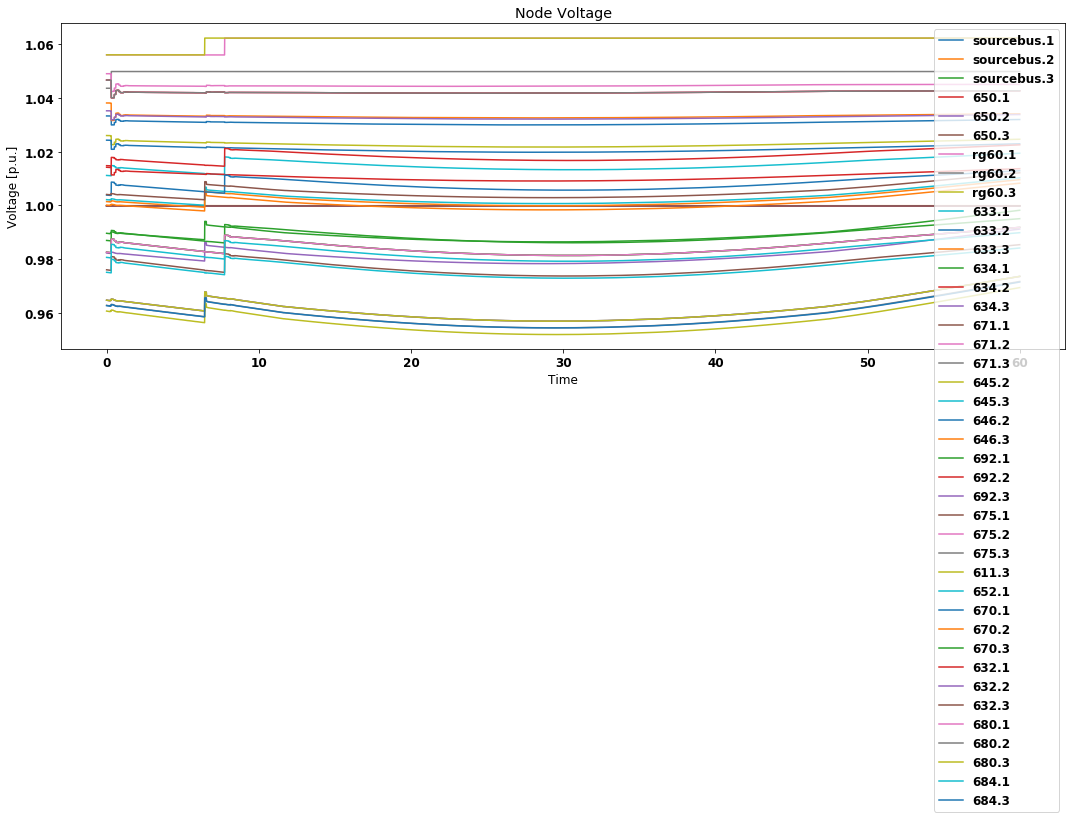

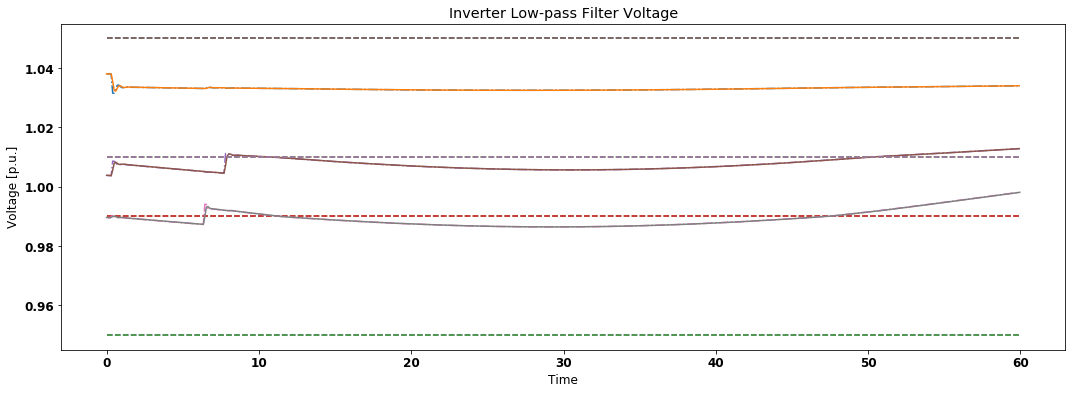

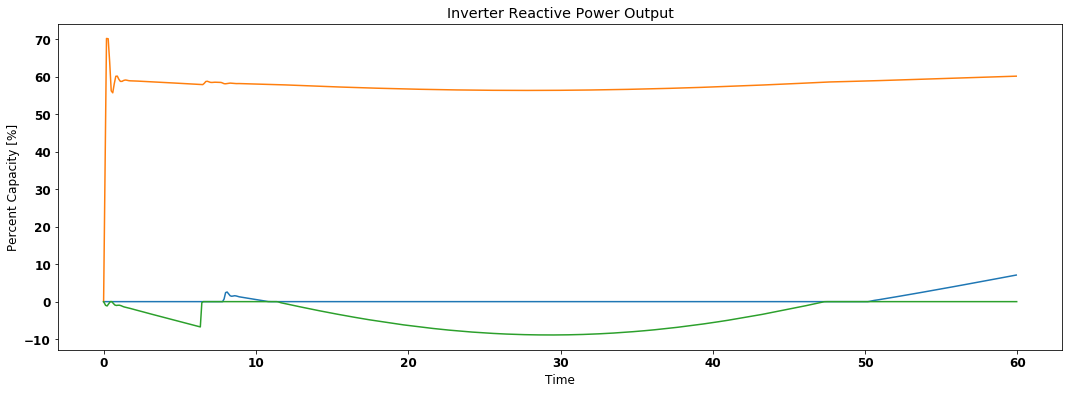

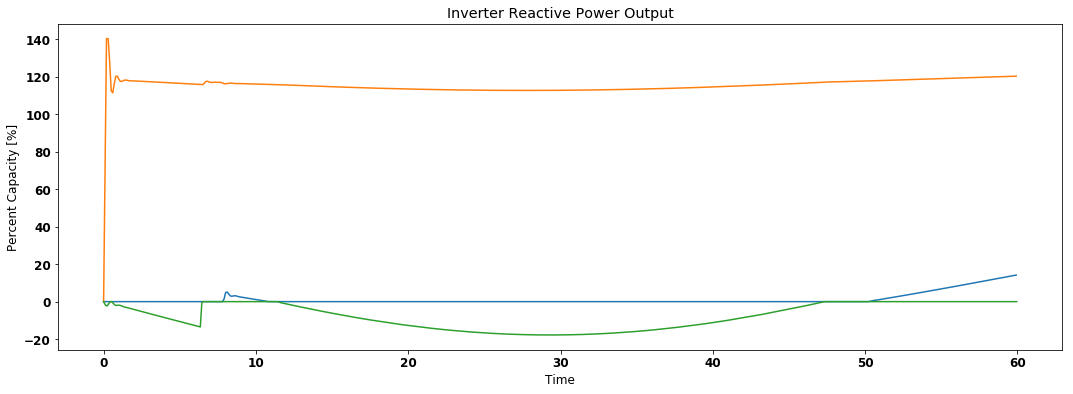

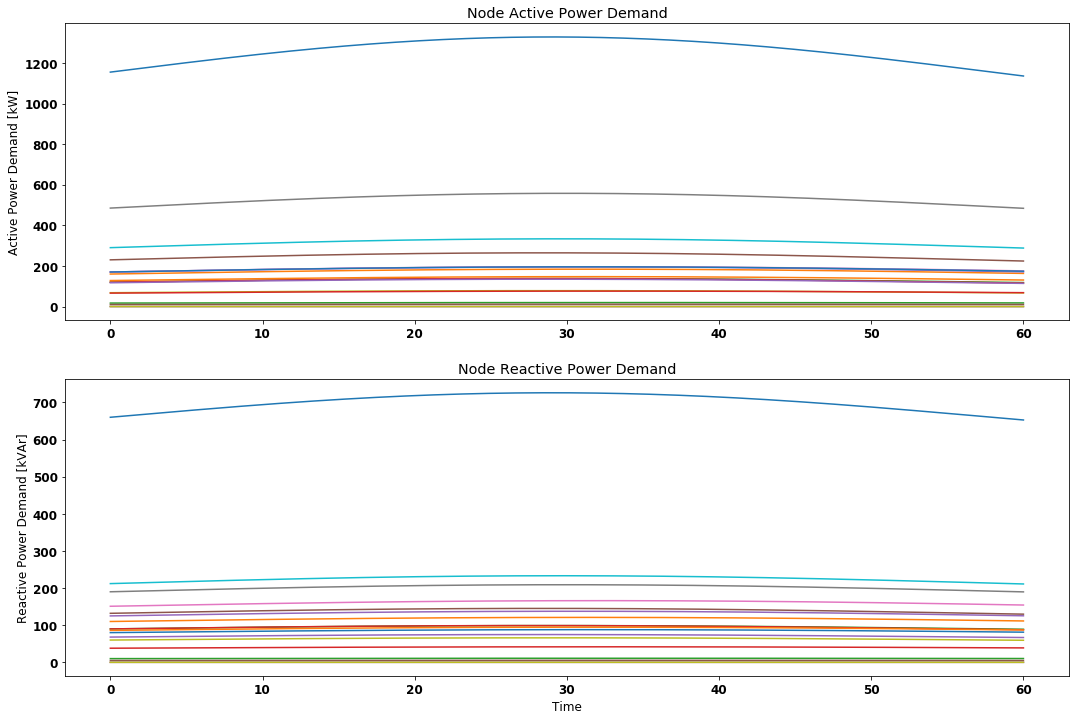

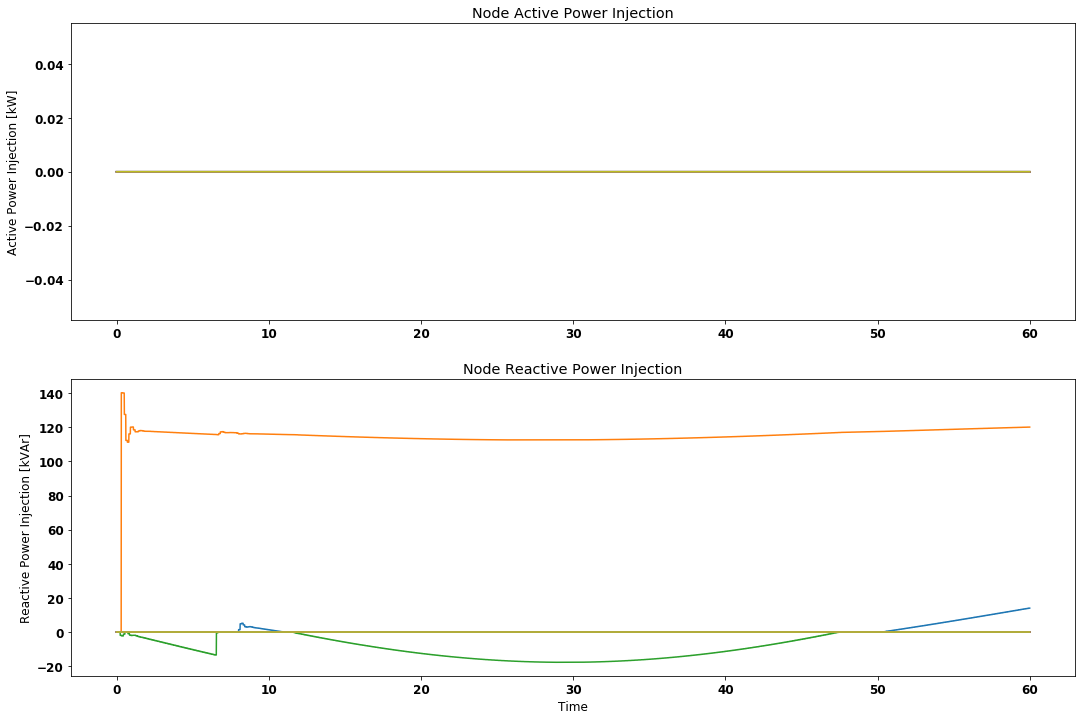

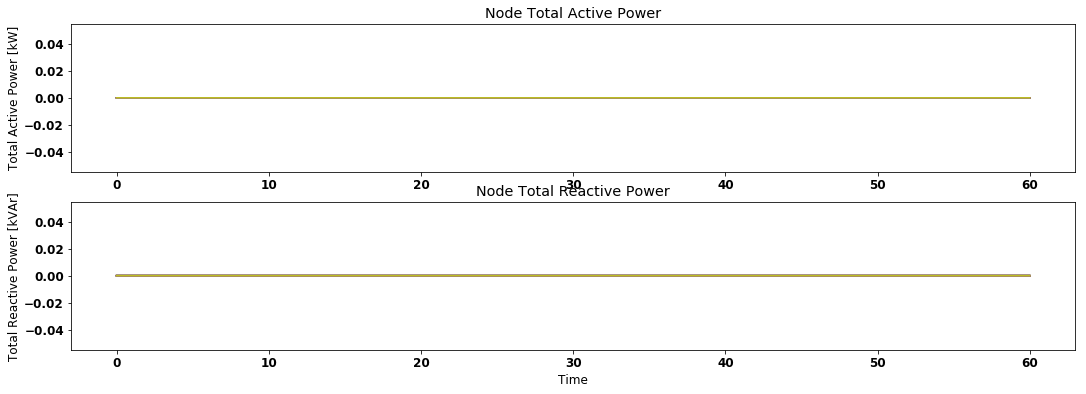

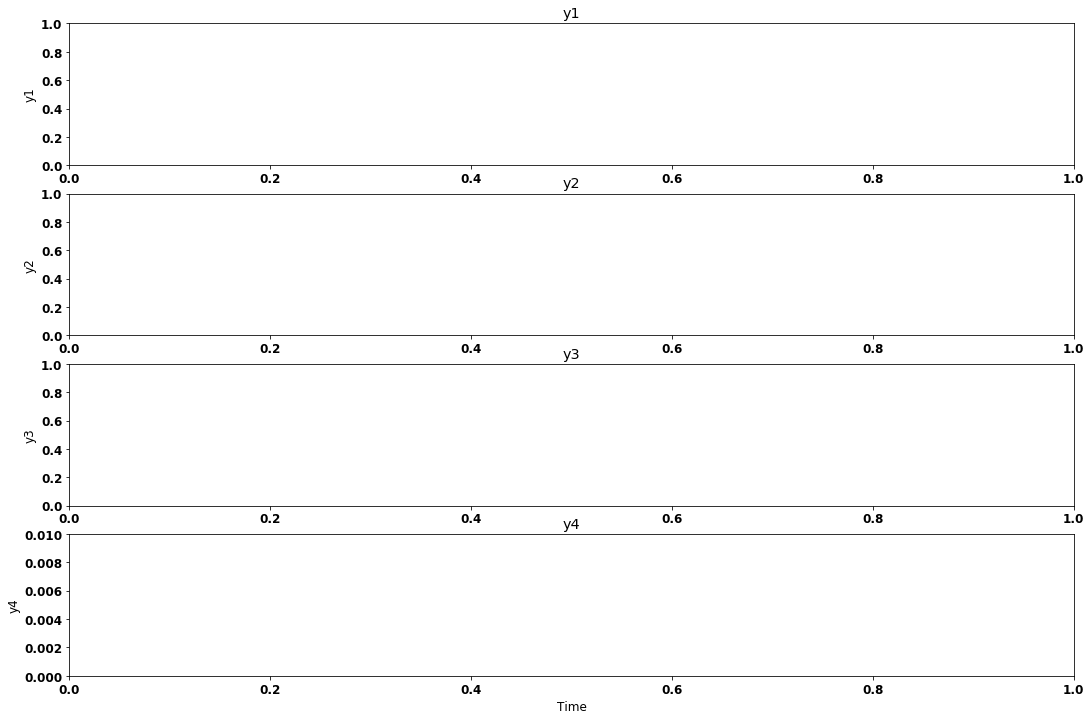

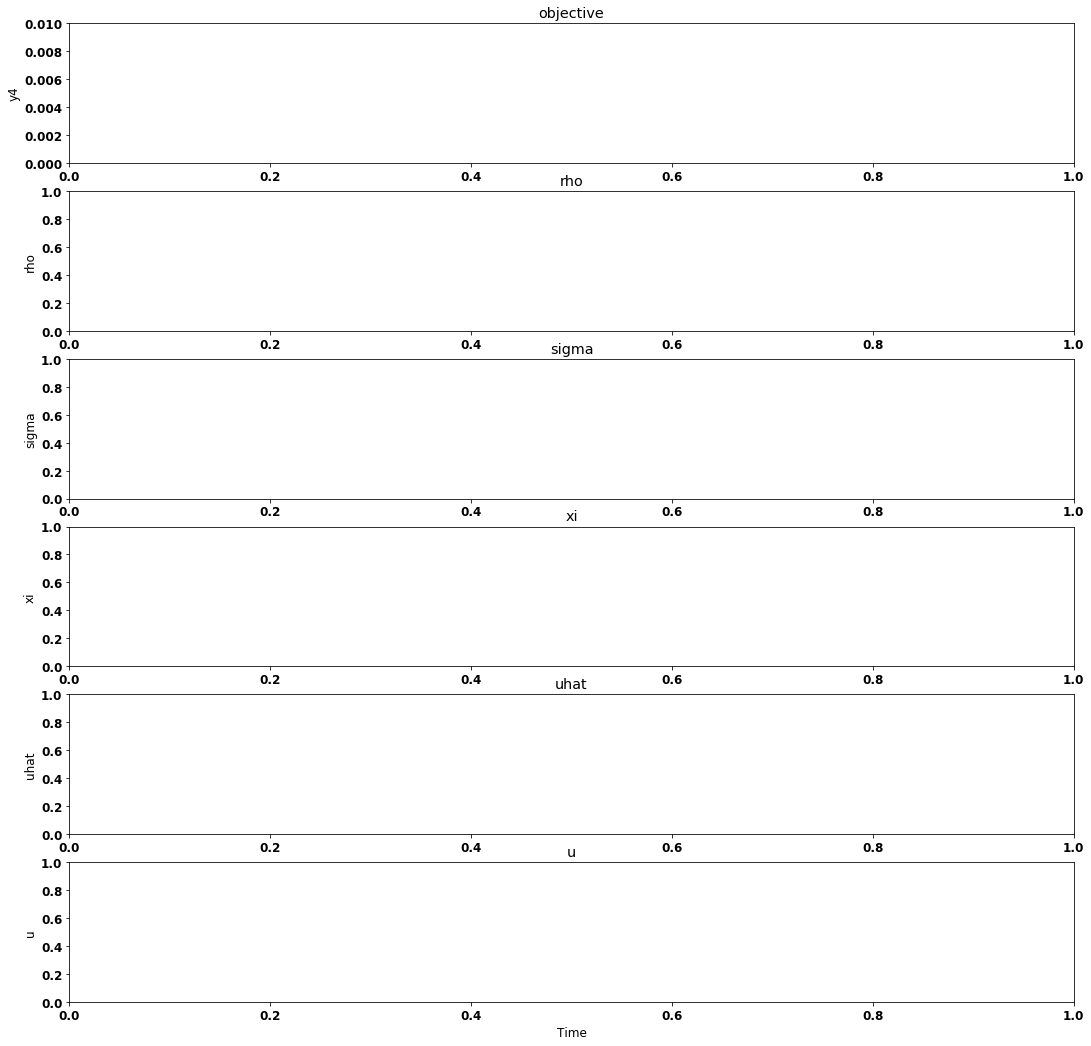

In [13]:
font = {'weight':'bold', 'size':12}

plt.rc('font', **font)

plotStartTimeStep = 0
plotEndTimeStep = len(time)

# plotStartTimeStep = 12*3600 + 1
# plotEndTimeStep = 12*3600 + 1 + 300

# time = np.arange(plotStartTimeStep,plotEndTimeStep)

# timehh = ((time-1)/3600).astype(int)
# timemm = ((time-1) - 3600*timehh)/60

# timeplot = timehh.astype(float) + timemm/100

# fig = plt.figure(figsize=[18,6])
# # for k1 in range(0,LoadBusVoltage.shape[1]):
# for k1 in range(len(LoadBuses)):
# #     plt.plot(time,LoadBusVoltage[:,k1])
#     plt.plot(time,LoadBusVoltage[:,k1] - np.mean(LoadBusVoltage[:,k1]))
# #     print(LoadBuses[k1])
# plt.title('Node Voltage')
# plt.xlabel('Time')
# plt.ylabel('Voltage [p.u.]')
# plt.show()

# dss.Circuit.SetActiveBus(AllBuses[k1])
#         tempVoltagePU = dss.Bus.puVmagAngle()[::2]
#         if dss.Bus.Nodes() == [1]:

fig = plt.figure(figsize=[18,6])
# for k1 in range(0,LoadBusVoltage.shape[1]):
for k1 in range(len(AllBuses)):
    dss.Circuit.SetActiveBus(AllBuses[k1])
    for ph in dss.Bus.Nodes():
        plt.plot(time,AllBusVoltage[:,ph-1,k1],label=AllBuses[k1]+'.'+str(ph))
#     print(LoadBuses[k1])
plt.title('Node Voltage')
plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.legend()
plt.show()

fig = plt.figure(figsize=[18,6])
for k1 in range(0,len(inverterlist)):
#     plt.plot(inverterlist[k1].Vmeas[:])
    plt.plot(inverterlist[k1].timeop,inverterlist[k1].VBPhist[:],'--')
    plt.plot(inverterlist[k1].timeop,inverterlist[k1].Vmeas[:],'-.')
    plt.plot(inverterlist[k1].timeop,inverterlist[k1].Vlp[:])
# plt.ylim([0.85, 1.05])
plt.title('Inverter Low-pass Filter Voltage')
plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.show()

fig = plt.figure(figsize=[18,6])
for k1 in range(0,len(inverterlist)):
    plt.plot(inverterlist[k1].timeop,inverterlist[k1].reactive_power)
# plt.ylim([-100, 100])
plt.title('Inverter Reactive Power Output')
plt.xlabel('Time')
plt.ylabel('Percent Capacity [%]')
plt.show()

fig = plt.figure(figsize=[18,6])
for k1 in range(0,len(inverterlist)):
    plt.plot(inverterlist[k1].timeop,inverterlist[k1].qin)
# plt.ylim([-100, 100])
plt.title('Inverter Reactive Power Output')
plt.xlabel('Time')
plt.ylabel('Percent Capacity [%]')
plt.show()

# fig = plt.figure(figsize=[18,6])
# plt.plot(time,PloadTS[:,:])
# plt.plot(time,QloadTS[:,:])
# plt.title('Load Demands')
# plt.xlabel('Time')
# plt.ylabel('Percent Capacity [%]')
# plt.show()

fig = plt.figure(figsize=[18,12])
plt.subplot(2,1,1)
plt.plot(time,PloadTS[:,:])
plt.title('Node Active Power Demand')
# plt.xlabel('Time')
plt.ylabel('Active Power Demand [kW]')
plt.subplot(2,1,2)
plt.plot(time,QloadTS[:,:])
plt.title('Node Reactive Power Demand')
plt.xlabel('Time')
plt.ylabel('Reactive Power Demand [kVAr]')
plt.show()

# fig = plt.figure(figsize=[18,6])
# plt.plot(time,PinjTS[:,:])
# plt.plot(time,QinjTS[:,:])
# plt.title('Injection')
# plt.show()

fig = plt.figure(figsize=[18,12])
plt.subplot(2,1,1)
plt.plot(time,PinvTS[:,:])
plt.title('Node Active Power Injection')
# plt.xlabel('Time')
plt.ylabel('Active Power Injection [kW]')
plt.subplot(2,1,2)
plt.plot(time,QinvTS[:,:])
plt.title('Node Reactive Power Injection')
plt.xlabel('Time')
plt.ylabel('Reactive Power Injection [kVAr]')
plt.show()

# fig = plt.figure(figsize=[18,6])
# plt.plot(time,PtotalTS[:,:])
# plt.plot(time,QtotalTS[:,:])
# plt.title('Total')
# plt.show()

fig = plt.figure(figsize=[18,6])
plt.subplot(2,1,1)
plt.plot(time,PtotalTS[:,:])
plt.title('Node Total Active Power')
# plt.xlabel('Time')
plt.ylabel('Total Active Power [kW]')
plt.subplot(2,1,2)
plt.plot(time,QtotalTS[:,:])
plt.title('Node Total Reactive Power')
plt.xlabel('Time')
plt.ylabel('Total Reactive Power [kVAr]')
plt.show()

fig = plt.figure(figsize=[18,12])
plt.subplot(4,1,1)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].y1)
plt.title('y1')
# plt.xlabel('Time')
plt.ylabel('y1')
plt.subplot(4,1,2)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].y2)
plt.title('y2')
plt.ylabel('y2')
plt.subplot(4,1,3)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].y3)
plt.title('y3')
plt.ylabel('y3')
plt.subplot(4,1,4)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].y4)
plt.title('y4')
plt.xlabel('Time')
plt.ylabel('y4')
plt.ylim([1e-10, 1e-2])
plt.show()

fig = plt.figure(figsize=[18,18])
plt.subplot(6,1,1)
for k1 in range(len(esclist)):
    plt.semilogy(esclist[k1].timeop,esclist[k1].y4)
plt.title('objective')
plt.ylabel('y4')
plt.ylim([1e-10, 1e-2])
plt.subplot(6,1,2)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].rho)
plt.title('rho')
plt.ylabel('rho')
plt.subplot(6,1,3)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].sigma)
plt.title('sigma')
plt.ylabel('sigma')
plt.subplot(6,1,4)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].xi)
plt.title('xi')
plt.ylabel('xi')
plt.subplot(6,1,5)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].uhat)
plt.title('uhat')
plt.ylabel('uhat')
plt.subplot(6,1,6)
for k1 in range(len(esclist)):
    plt.plot(esclist[k1].timeop,esclist[k1].u)
plt.title('u')
plt.xlabel('Time')
plt.ylabel('u')
plt.show()

# print(timeplot)


ValueError: x and y must have same first dimension, but have shapes (9,) and (6001, 9)

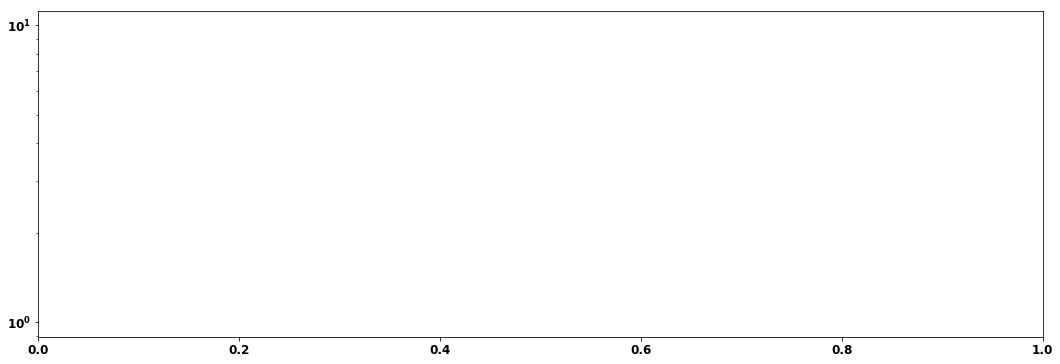

In [7]:
from scipy import signal
import matplotlib.pyplot as plt

fs = 100
N = len(time)

fig = plt.figure(figsize=[18,6])
for k1 in range(AllBusVoltage.shape[1]):
    x = AllBusVoltage[:,k1]
    f, Pxx_den = signal.periodogram(x, fs)
    plt.semilogy(f, Pxx_den)
    plt.xlim([0, 3])
    plt.ylim([1e-10, 1e-2])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [ ]:
inverter_params = pd.read_csv('inverter_params.csv',header=0,index_col=0)

inverter_params['Toff'] = 1/100*np.floor(10*np.random.rand(inverter_params.shape[0]))

inverter_params['Toff'].loc[2]

In [ ]:
LoadBuses = dss.Loads.AllNames()
for k1 in range(len(LoadBuses)):
    dss.Loads.Name(LoadBuses[k1])
    dss.CktElement.AllPropertyNames()
    print(dss.Loads.IsDelta())
    print(dss.CktElement.BusNames()[0].split('.',1))

In [ ]:
for k1 in range(len(AllBuses)):
    dss.Circuit.SetActiveBus(AllBuses[k1])
    print(dss.Bus.Nodes())

In [ ]:
for k1 in range(len(AllBuses)):
    dss.Circuit.SetActiveBus(AllBuses[k1])
    print(AllBuses[k1])
    print(dss.Bus.Nodes())
    print(dss.Bus.puVmagAngle()[::2])

In [ ]:
for k1 in range(len(AllLoads)):
    dss.Loads.Name(AllLoads[k1])
    print(dss.Loads.Name())
    print(dss.Loads.IsDelta())
    print(dss.CktElement.NodeOrder())    
    print(dss.Loads.kV())
    print(dss.Loads.kVABase())
    print(dss.Loads.kW())
    print(dss.Loads.kvar())    
    print('')
    

In [ ]:
AllBuses == inverterlist[0].nodename

In [ ]:
str(inverterlist[0].nodename) in AllBuses

In [ ]:
for k1 in range(len(dss.Circuit.AllBusNames())):
    dss.Circuit.SetActiveBus(dss.Circuit.AllBusNames()[k1])
    print(dss.Bus.Name())
    print(dss.Bus.kVBase())